In [1]:
import numpy as np
import pandas as pd
from pandas import pivot_table
from sklearn.cross_validation import KFold, cross_val_score, train_test_split
import scipy.sparse as sparse
from scipy.sparse.linalg import spsolve
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

C:\Users\Prashant\AppData\Local\conda\conda\envs\py35\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
df = pd.read_csv("../Data/Replaced.csv",encoding="ISO-8859-1")
df.head()

,Unnamed: 0,id,brand,categories,dateAdded,dateUpdated,ean,keys,manufacturer,manufacturerNumber,...,reviews_id,reviews.numHelpful,rating,sourceURLs,text,title,userCity,userProvince,username,upc
0,0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",2017-07-25T00:52:42Z,2018-02-05T08:36:58Z,6.03E+11,"602537205981,universalmusic/14331328,universal...",Universal Music Group / Cash Money,14331328,...,NaN,0.0,5,https://redsky.target.com/groot-domain-api/v1/...,i love this album. it's very good. more to the...,Just Awesome,Japan,NaN,Joshua,6.03E+11
1,1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",2017-07-25T05:16:03Z,2018-02-05T11:27:45Z,73416000391,lundbergorganiccinnamontoastricecakes/b000fvzw...,Lundberg,574764,...,100209113.0,NaN,5,https://www.walmart.com/reviews/product/29775278,Good flavor. This review was collected as part...,Good,Japan,NaN,Dorothy W,73416000391
2,2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",2017-07-25T05:16:03Z,2018-02-05T11:27:45Z,73416000391,lundbergorganiccinnamontoastricecakes/b000fvzw...,Lundberg,574764,...,100209113.0,NaN,5,https://www.walmart.com/reviews/product/29775278,Good flavor.,Good,America,NaN,Dorothy W,73416000391
3,3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",2017-07-25T16:26:19Z,2018-02-05T11:25:51Z,67981934427,"kylovesensualitypleasuregel/b00u2whx8s,0679819...",K-Y,67981934427,...,113026909.0,NaN,1,https://www.walmart.com/reviews/product/43383370,I read through the reviews on here before look...,Disappointed,China,NaN,Rebecca,67981934427
4,4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",2017-07-25T16:26:19Z,2018-02-05T11:25:51Z,67981934427,"kylovesensualitypleasuregel/b00u2whx8s,0679819...",K-Y,67981934427,...,171267657.0,NaN,1,https://www.walmart.com/reviews/product/43383370,My husband bought this gel for us. The gel cau...,Irritation,China,NaN,Walker557,67981934427


In [3]:
drop_cols = ['Unnamed: 0','brand','categories','categories','dateAdded','dateUpdated','keys','manufacturer','name','reviewsdate','dateSeen','sourceURLs','text','title','userCity','upc','userProvince']
df = df.drop(drop_cols,axis=1)

df.head()

,id,ean,manufacturerNumber,didPurchase,doRecommend,reviews_id,reviews.numHelpful,rating,username
0,AV13O1A8GV-KLJ3akUyj,6.03E+11,14331328,NaN,NaN,NaN,0.0,5,Joshua
1,AV14LG0R-jtxr-f38QfS,73416000391,574764,True,True,100209113.0,NaN,5,Dorothy W
2,AV14LG0R-jtxr-f38QfS,73416000391,574764,True,True,100209113.0,NaN,5,Dorothy W
3,AV16khLE-jtxr-f38VFn,67981934427,67981934427,False,False,113026909.0,NaN,1,Rebecca
4,AV16khLE-jtxr-f38VFn,67981934427,67981934427,False,False,171267657.0,NaN,1,Walker557


In [4]:
product_names = df.id.tolist()
#product_names

product_names = [' {0} '.format(elem) for elem in product_names]
product_names[0:5]

[' AV13O1A8GV-KLJ3akUyj ',
 ' AV14LG0R-jtxr-f38QfS ',
 ' AV14LG0R-jtxr-f38QfS ',
 ' AV16khLE-jtxr-f38VFn ',
 ' AV16khLE-jtxr-f38VFn ']

In [5]:
df.dtypes

df['id'].nunique()

600

In [6]:
#df=df.withColumn("rating", df["rating"].cast(IntegerType()))

df = df.fillna({'rating':'3'})


df['didPurchase'].fillna(True, inplace=True)
df['doRecommend'].fillna(True, inplace=True)

df.didPurchase = (df.didPurchase)*1
df.doRecommend = (df.doRecommend)*1

df.fillna(0, inplace=True)

In [7]:
df.head()

,id,ean,manufacturerNumber,didPurchase,doRecommend,reviews_id,reviews.numHelpful,rating,username
0,AV13O1A8GV-KLJ3akUyj,6.03E+11,14331328,1,1,0.0,0.0,5,Joshua
1,AV14LG0R-jtxr-f38QfS,73416000391,574764,1,1,100209113.0,0.0,5,Dorothy W
2,AV14LG0R-jtxr-f38QfS,73416000391,574764,1,1,100209113.0,0.0,5,Dorothy W
3,AV16khLE-jtxr-f38VFn,67981934427,67981934427,0,0,113026909.0,0.0,1,Rebecca
4,AV16khLE-jtxr-f38VFn,67981934427,67981934427,0,0,171267657.0,0.0,1,Walker557


In [8]:
def get_hash(x):
  return abs(hash(x)) % 10**9
df['username'] = df['username'].apply(get_hash)
df['id'] = df['id'].apply(get_hash)

df.head()

,id,ean,manufacturerNumber,didPurchase,doRecommend,reviews_id,reviews.numHelpful,rating,username
0,53407946,6.03E+11,14331328,1,1,0.0,0.0,5,505572636
1,694259193,73416000391,574764,1,1,100209113.0,0.0,5,725423346
2,694259193,73416000391,574764,1,1,100209113.0,0.0,5,725423346
3,855306114,67981934427,67981934427,0,0,113026909.0,0.0,1,237343879
4,855306114,67981934427,67981934427,0,0,171267657.0,0.0,1,165581099


In [9]:
rp = df.pivot_table(columns=['id'],index=['username'],values='rating')
rp.head()

id,2373580,2997938,5113732,6890599,7931724,8396112,9117229,15448447,16570664,16728444,...,977013119,978060905,978091608,980451012,980826361,981553197,982006555,997270739,999021315,999318890
username,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
47986,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
79232,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
85729,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
108472,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
rp = rp.fillna(0); # Replace NaN
rp.head()

id,2373580,2997938,5113732,6890599,7931724,8396112,9117229,15448447,16570664,16728444,...,977013119,978060905,978091608,980451012,980826361,981553197,982006555,997270739,999021315,999318890
username,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
47986,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
79232,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
85729,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
108472,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
Q = rp.values
Q

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [12]:
Q.shape

(58089, 600)

In [13]:
#We have 58089 users and 600 items(products) in our Q matrix.
Q=Q[:500,:200]

In [14]:
W = Q>0.5
W[W == True] = 1
W[W == False] = 0
# To be consistent with our Q matrix
W = W.astype(np.float64, copy=False)

In [15]:
W

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [16]:
#parameters

lambda_ = 0.1
n_factors = 100
m, n = Q.shape
n_iterations = 20

In [17]:
#X = 5 * np.random.rand(m, n_factors) 
#Y = 5 * np.random.rand(n_factors, n)

X = 7 * np.random.rand(m, n_factors) 
Y = 7 * np.random.rand(n_factors, n)

In [18]:
def get_error(Q, X, Y, W):
      return np.sum((W * (Q - np.dot(X, Y)))**2)

In [20]:
product_names = df.id.tolist()
product_names = [' {0} '.format(elem) for elem in product_names]
product_names[0:5]

[' 53407946 ', ' 694259193 ', ' 694259193 ', ' 855306114 ', ' 855306114 ']

In [21]:
##Weighted Alternating Least Squares Approach

In [26]:
weighted_errors = []
for ii in range(n_iterations):
    for u, Wu in enumerate(W):
        X[u] = np.linalg.solve(np.dot(Y, np.dot(np.diag(Wu), Y.T)) + lambda_ * np.eye(n_factors),
                               np.dot(Y, np.dot(np.diag(Wu), Q[u].T))).T
    for i, Wi in enumerate(W.T):
        Y[:,i] = np.linalg.solve(np.dot(X.T, np.dot(np.diag(Wi), X)) + lambda_ * np.eye(n_factors),
                                 np.dot(X.T, np.dot(np.diag(Wi), Q[:, i])))
    weighted_errors.append(get_error(Q, X, Y, W))
    #print('{}th iteration is completed'.format(ii))
weighted_Q_hat = np.dot(X,Y)
print('Error of rated product: {}'.format(get_error(Q, X, Y, W)))

Error of rated product: 0.7192450459001117


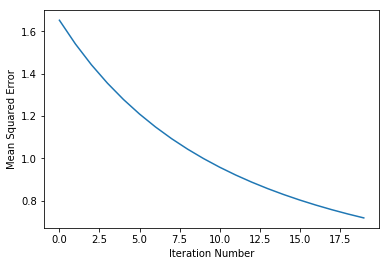

In [27]:
plt.plot(weighted_errors);
plt.xlabel('Iteration Number');
plt.ylabel('Mean Squared Error');

In [28]:
def print_recommendations(W=W, Q=Q, Q_hat=weighted_Q_hat, product_names=product_names):
    Q_hat -= np.min(Q_hat)
    Q_hat *= float(5) / np.max(Q_hat)
    product_ids = np.argmax(Q_hat -  5* W, axis=1)
    for jj, product_id in zip(range(m), product_ids):
        print('User {} liked: {}'.format(jj + 1, ', '.join([product_names[ii] for ii, qq in enumerate(Q[jj]) if qq > 3])))
        print('User {} did not like: {}'.format(jj + 1, ', '.join([product_names[ii] for ii, qq in enumerate(Q[jj]) if qq < 3 and qq != 0])))
        print('User {} recommended product is {}- with predicted rating: {:.3f}'.format(jj + 1, product_names[product_id], Q_hat[jj, product_id]))
        print(100 *  '-')
print_recommendations()

User 1 liked:  183756145 
User 1 did not like: 
User 1 recommended product is  855306114 - with predicted rating: 4.786
----------------------------------------------------------------------------------------------------
User 2 liked:  855306114 
User 2 did not like: 
User 2 recommended product is  15448447 - with predicted rating: 1.131
----------------------------------------------------------------------------------------------------
User 3 liked: 
User 3 did not like: 
User 3 recommended product is  53407946 - with predicted rating: 0.000
----------------------------------------------------------------------------------------------------
User 4 liked: 
User 4 did not like: 
User 4 recommended product is  53407946 - with predicted rating: 0.000
----------------------------------------------------------------------------------------------------
User 5 liked: 
User 5 did not like: 
User 5 recommended product is  53407946 - with predicted rating: 0.000
---------------------------------

User 340 did not like: 
User 340 recommended product is  53407946 - with predicted rating: 0.000
----------------------------------------------------------------------------------------------------
User 341 liked: 
User 341 did not like: 
User 341 recommended product is  53407946 - with predicted rating: 0.000
----------------------------------------------------------------------------------------------------
User 342 liked: 
User 342 did not like: 
User 342 recommended product is  53407946 - with predicted rating: 0.000
----------------------------------------------------------------------------------------------------
User 343 liked:  705013878 
User 343 did not like: 
User 343 recommended product is  855306114 - with predicted rating: 1.967
----------------------------------------------------------------------------------------------------
User 344 liked: 
User 344 did not like: 
User 344 recommended product is  53407946 - with predicted rating: 0.000
-------------------------------